In [79]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
AU = 1.49598e+13 # Average distance from the Earth to the Sun in cm
G = 6.67259e-08 # universal gravitational constant in cgs units 
msun = 1.9891e33 # mass of the Sun in grams
yr =  365.25 * 24 * 60 * 60 # 1 year in seconds
kpc = 3.08568e+21 # kiloparsec in cm


In [83]:
def time_stepping(x0, v0, t0, tend, dt, *args, acc_func=None):
    """
    Implements time stepping for a particle's motion in three dimensions.
    """
    # initialize time and arrays to keep coordinate and velocity components
    t = t0
    x, v = np.array(x0), np.array(v0)

    # Initialize lists to store times, coordimates, and velocities along trajectory
    time, xt, vt = [np.copy(t)], [np.copy(x0)], [np.copy(v0)]

    # Time stepping loop
    while t < tend:
        # Calculate acceleration components using the provided function
        a = np.array(acc_func(x, *args))

        # Update velocity and position using the KD scheme
        v += a * dt
        x += v * dt

        # Update time
        t += dt

        # Append current state to the trajectory
        time.append(t)
        xt.append(np.copy(x))
        vt.append(np.copy(v))
        
    return np.array(time), np.array(xt), np.array(vt)

In [85]:
def plot_traj_xy_xz(xt, xlab1='$x$', ylab1='$y$', xlab2='$x$', ylab2='$z$', lw=0.5, 
                    xlims=[-1.1, 1.1], ylims=[-1.1, 1.1], xlims2=None, ylims2=None, figsize=(7,3)):
    '''
    Given helper function to plot trajectory in the x-y and x-z projections using Matplotlib 
    '''
    fig, ax = plt.subplots(1, 2, figsize=figsize) # define sub-panels
    fig.subplots_adjust(wspace=0.4)

    ax[0].plot(xt[:,0], xt[:,1], lw=lw)
    ax[0].set_xlim(xlims) # set x, and y axes limits 
    ax[0].set_ylim(ylims)
    ax[0].set_ylabel(ylab1) # add labels to axes
    ax[0].set_xlabel(xlab1)

    ax[1].plot(xt[:,0], xt[:,2], lw=lw)
    if xlims2 is None: 
        ax[1].set_xlim(xlims) # set x, and y axes limits 
    else:
        ax[1].set_xlim(xlims2)
    if ylims2 is None: 
        ax[1].set_ylim(ylims) # set x, and y axes limits 
    else:
        ax[1].set_ylim(ylims2)

    ax[1].set_xlabel(xlab2)
    ax[1].set_ylabel(ylab2)
    plt.show()

In [87]:
def acc_point_mass(x, *args):
    """
    Computes acceleration from a point mass at the position with coordinates in x
    """
    m = args[0]
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    return -G * m/r**3 * x

In [89]:
def acc_nfw(x, *args):
    '''Computes acceleration due to the NFW mass distribution at the distance x from the origin
    Parameters:
       x: arrays with 3 coordinates in the system where center of the NFW potential is at the origin
       args: a tuple of size 2 containing total mass M200 in units of Sun's mass and dimensionless concentration c
    Returns:
       numpy array with 3 components of the acceleration
    '''
    m200, c = args[0], args[1]
    r200 = 206.285 * (m200/1e12)**(1./3) # R200 in kpc
    rs = r200 / c * kpc
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)

    acc = G * m200 * msun / (np.log(1+c) - c/(1+c)) * (r/(r+rs) - np.log(1+r/rs))/r**3 * x
    return acc

In [91]:
def fnfw(x): 
    '''
    Helper function for computing mass within a radius r for the NFW profile
    '''
    assert(x >= 0)
    return np.log(1.+x) - x/(1+x)

def vcirc_nfw(r0=8, m200=9e11, c=10):
    '''
    Compute circular velocity for input distance r0, m200, and concentration c assuming NFW profile
    
    Returns: 
        circular velocity at r0 in cm/s
    '''
    r200 = 206.285 * (m200/1e12)**(1./3) # R200 in kpc
    
    r0 = r0 * kpc
    rs = r200 / c * kpc

    mr0 = m200 * fnfw(r0/rs) / fnfw(c)

    vcirc = (G*mr0*msun / r0)**0.5
    return vcirc

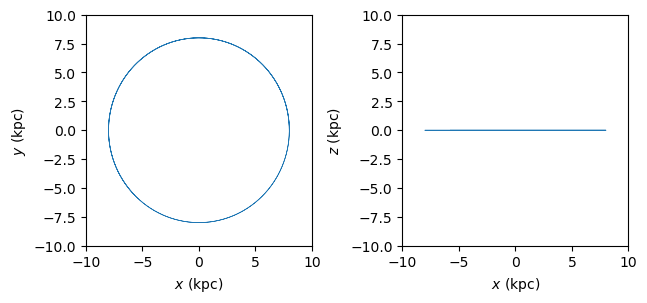

In [93]:
# set initial conditions
r0 = 8 
m200, c = 9e11, 10 # total mass of the Milky Way in Msun and halo concentration
args = (m200, c) 
vcirc = vcirc_nfw(r0=r0, m200=m200, c=c)

x0 = [r0*kpc, 0., 0.] # initial coordinates 
v0 = [0., vcirc, 0.] # initial velocity 

t0 = 0.
tend = 1e9 * yr # duration of calculation
dt = (tend - t0) / 10000. 


t, xt, vt = time_stepping(x0, v0, t0, tend, dt, *args, acc_func=acc_nfw)

t /= (1e6*yr)
xt /= kpc

plot_traj_xy_xz(xt, xlab1=r'$x\rm\ (kpc)$', ylab1=r'$y\rm\ (kpc)$', 
                 xlab2=r'$x\rm\ (kpc)$', ylab2=r'$z\rm\ (kpc)$', 
                    xlims=[-10,10], ylims=[-10,10])

#### Modeling Sagittarius dwarf trajectory in the NFW + disk potential 

The Sagittarius Dwarf Galaxy has an orbit that loops around the center of our galaxy and has passed near the plane of the Milky Way disk ($z=0$) a few times. 

A good match to the orbit of the Sagittarius galaxy over the past 4 billion years can be obtained with initial coordinates and velocity components:

* $x= -37.05$ kpc, $y=-24.18$ kpc, $z=51.34$ kpc, where kpc is kiloparsec (thousand parsecs) equal to $3.08568\times 10^{21}$ cm.  
<br>

* $v_x = -8.406\times 10^6$ cm/s, $2.760\times 10^6$ cm/s, $-6.441\times 10^6$ cm/s.

Miyamoto-Nagai model for the mass distribution in the disk, characterized by the potential: 

$$\phi(R,z) = -\frac{GM_{\rm disk}}{\left[R^2 + (\sqrt{z^2 + b^2} + a)^2\right]^{1/2}},$$

Acceleration components due to mass distribution with this potential:

$$a_x = -\frac{\partial\phi}{\partial x} = -\frac{G M_{\text{disk}}}{\left(x^2 + y^2 + \left(a + \sqrt{b^2 + z^2}\right)^2\right)^{3/2}}\, x$$

$$a_y = -\frac{\partial\phi}{\partial y} = -\frac{G M_{\text{disk}}}{\left(x^2 + y^2 + \left(a + \sqrt{b^2 + z^2}\right)^2\right)^{3/2}}\,y$$

$$a_z = -\frac{\partial\phi}{\partial z} = -\frac{G M_{\text{disk}}}{\left(x^2 + y^2 + \left(a + \sqrt{b^2 + z^2}\right)^2\right)^{3/2}}\,\frac{ \left(a + \sqrt{b^2 + z^2}\right)}{\sqrt{b^2 + z^2} }\,z$$

Circular velocity for a particle in the midplane of the disk ($z=0$) for this potential:

$$V_{\rm circ, disk}\vert_{z=0} = \sqrt{R\frac{\partial\phi(R,z)}{\partial R}\vert_{z=0}}= \sqrt{\frac{G M_{\rm disk} R^2}{\left[R^2 + (a+b)^2\right]^{3/2}}}$$

Circular velocity overall:

$$v_{\rm circ}=\sqrt{v_{\rm circ,NFW}^2(r=8{\,\rm kpc}) + v_{\rm circ, disk}^2(r=8{\,\rm kpc})}$$

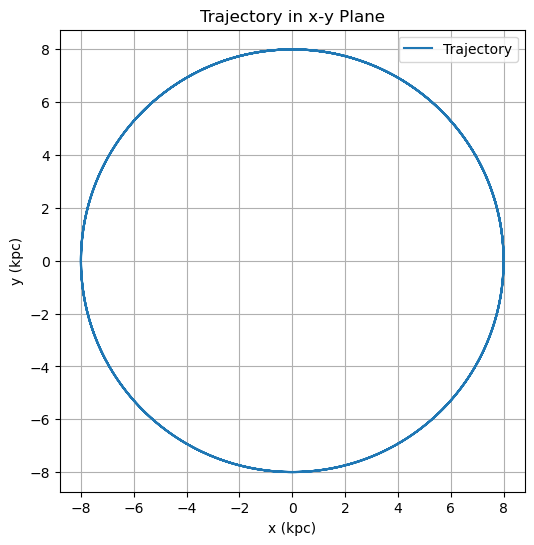

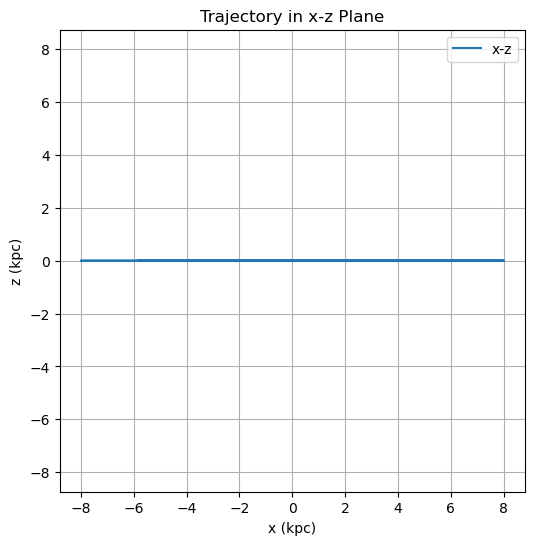

In [96]:
#Calculating accelerations due to disk in cm/s
def acc_disk(x_pos, M_disk, a, b, G=6.67259e-08):
    x, y, z = x_pos 

    R2 = x**2 + y**2
    sqrt = (z**2 + b**2)**0.5

    denom = (R2 + (a+sqrt)**2)**(3/2)
    num = G * M_disk
    
    a_x = -(num/denom) * x
    a_y = -(num/denom) * y
    a_z = -(num/denom) * ((a + sqrt)/sqrt) * z
    
    return np.array([a_x, a_y, a_z])

# Calculating v_circ,disk in cm/s
def v_circ_disk(x, y, z, M_disk, a, b, G=6.67259e-08):
    R2 = x**2 + y**2
    denom = (R2 + (a+b)**2)**(3/2)
    num = G * M_disk * R2

    v_disk = np.sqrt(num/denom)

    return v_disk

# Computing the sum of the accelerations due to NFW mass distribution and accelerations due to disk with parameters similar to Milky Way disk
def acc_sum(x, M_disk, a, b, c, G=6.67259e-08):
    nfw_acc_x, nfw_acc_y, nfw_acc_z = acc_nfw(x, m200, c)
    disk_acc_x, disk_acc_y, disk_acc_z = acc_disk(x, M_disk, a, b)
    acc_totx = nfw_acc_x + disk_acc_x
    acc_toty = nfw_acc_y + disk_acc_y
    acc_totz = nfw_acc_z + disk_acc_z
    
    acc_total = np.array([acc_totx, acc_toty, acc_totz])

    return acc_total

# Testing acceleration function by setting particle at the initial coordinates x=8 kpc and y=0, z=0 and initial velocity components: 
# v_x=0, v_y=v_circ, v_z=0
M_disk=(7e10*1.9891e33)
a = (3*3.08568e21)
b = (0.3*3.08568e21)

x0 = np.array([8*kpc, 0, 0])

v_nfw = vcirc_nfw(8, m200, c)
v_disk = v_circ_disk(8*kpc, 0, 0, M_disk, a, b)
vcirc = np.sqrt(v_nfw**2 + v_disk**2)

v0 = np.array([0, vcirc, 0])

t0 = 0
tend = 1000000000 * yr                  
dt = (tend - t0) / 100000 

t, xt, vt = time_stepping(x0, v0, t0, tend, dt, M_disk, a, b, c, acc_func=acc_sum)

xt /= kpc  
t /= 3.154e7 

# Plotting the trajectory of the particle in the x-y and x-z planes 
plt.figure(figsize=(6, 6))
plt.plot(xt[:, 0], xt[:, 1], label="Trajectory")
plt.xlabel("x (kpc)")
plt.ylabel("y (kpc)")
plt.title("Trajectory in x-y Plane")
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(xt[:, 0], xt[:, 2], label="x-z")
plt.xlabel("x (kpc)")
plt.ylabel("z (kpc)")
plt.title("Trajectory in x-z Plane")
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()
    

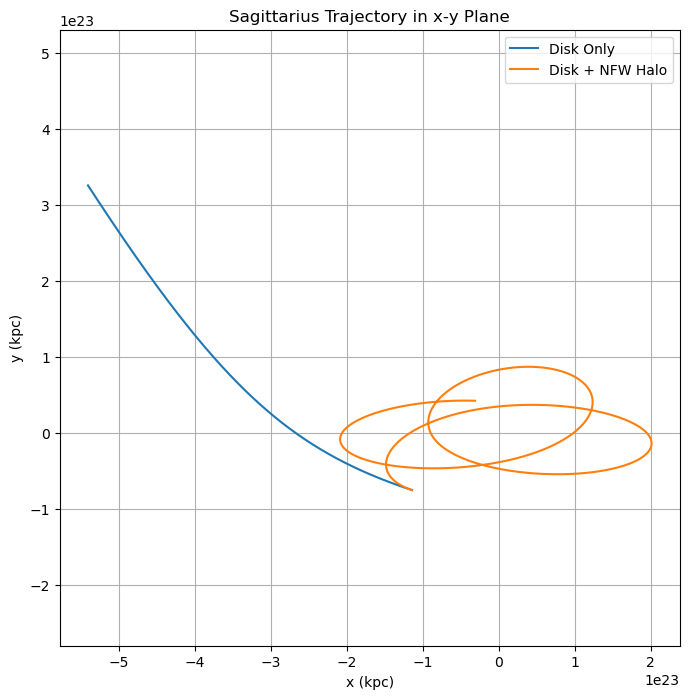

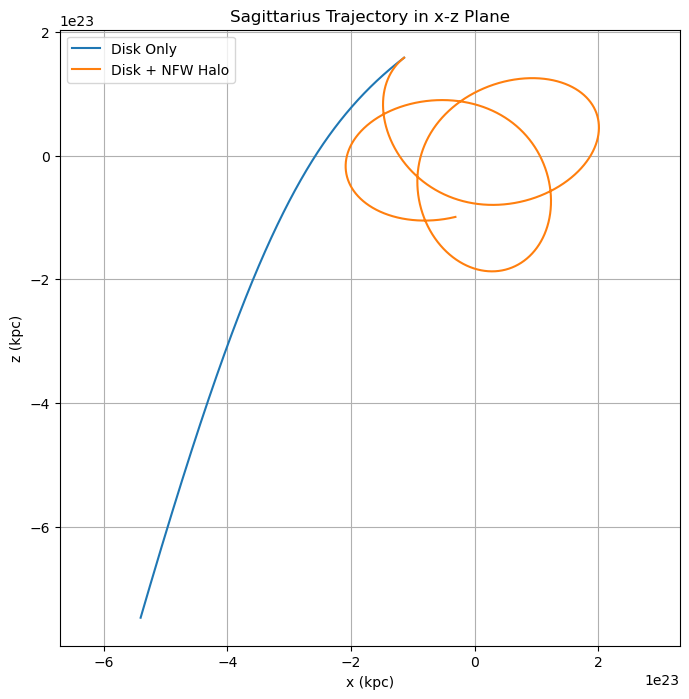

In [97]:
# Running the calculation of the trajectory for 4 gigayears
x0 = np.array([-37.05 * kpc, -24.18 * kpc, 51.34 * kpc])  # Position in cm
v0 = np.array([-8.406e6, 2.760e6, -6.441e6])  # Velocity in cm/s

a = 3*kpc
b = 0.3*kpc
t0 = 0
tend = 4e9 * yr 
dt = (tend - t0) / 10000. 

t, xt, vt = time_stepping(x0, v0, t0, tend, dt, M_disk, a, b, G, acc_func=acc_disk)
t2, xt2, vt2 = time_stepping(x0, v0, t0, tend, dt, M_disk, a, b, c, acc_func=acc_sum)

# Plotting the resulting trajectory in x-y and x-z projections using only the disk contribution to the potential, 
# then using both disk and NFW halo contributions
plt.figure(figsize=(8, 8))
plt.plot(xt[:, 0], xt[:, 1], label="Disk Only")
plt.plot(xt2[:, 0], xt2[:, 1], label="Disk + NFW Halo")
plt.xlabel("x (kpc)")
plt.ylabel("y (kpc)")
plt.title("Sagittarius Trajectory in x-y Plane")
plt.legend()
plt.grid()
plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.axis("equal")
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(xt[:, 0], xt[:, 2], label="Disk Only")
plt.plot(xt2[:, 0], xt2[:, 2], label="Disk + NFW Halo")
plt.xlabel("x (kpc)")
plt.ylabel("z (kpc)")
plt.title("Sagittarius Trajectory in x-z Plane")
plt.legend()
plt.grid()
plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.axis("equal")
plt.show()

The trajectory obtained by using the dark matter halo is closer to the real orbit of Sagittarius. It has a similar rosette pattern; in general, it is visually very similar. The plot without the dark matter halo is very different from the true orbit. This makes sense, because the dark matter halo provides enough gravitational force to keep the galaxy in orbit; it can't be neglected. 